In [1]:
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


In [2]:
class Preprocessing:
    # def __init__(self, data):
    #     self.data = data

    @classmethod
    def mean_imputation(self, data, inplace = False):
        data.fillna(data.mean(), inplace = inplace)

    @classmethod
    def median_imputation(self, data, inplace = False):
        data.fillna(data.median(), inplace = inplace)

    @classmethod
    def mode_imputation(self, data, inplace = False):
        data.fillna(data.mode(), inplace = inplace)

    @classmethod
    def tree_imputation(self, data):
        missing_cols = [col for col in data.columns if data[col].isnull().sum() > 0]
        non_missing_cols = [col for col in data.columns if data[col].isnull().sum() == 0]
    
        for col in missing_cols:
            model = BaggingRegressor(DecisionTreeRegressor(), n_estimators = 40, max_samples = 1.0,
                                     max_features = 1.0, bootstrap = False, n_jobs = -1)

            col_missing = data[data[col].isnull()]
            temp = data.drop(data[data[col].isnull()].index, axis = 0)
            
            X = temp.loc[:, non_missing_cols]
            y = temp[col]
    
            model.fit(X, y)
    
            y_pred = model.predict(col_missing[non_missing_cols])
    
            data.loc[col_missing.index, col] = y_pred
        
        return data

    @classmethod
    def find_outliers(self, data, feature):
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    

    @classmethod
    def encoding(self, df):
        education_mapping = {'Unknown': 0, 'Uneducated': 1, 'High School': 2, 'College': 3,
                             'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6}
        income_mapping = {'Unknown': 0, 'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3,
                          '$80K - $120K': 4, '$120K +': 5}
        card_mapping = {'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}
        
        # Apply mapping to each categorical feature
        df['Education_Level'] = df['Education_Level'].map(education_mapping)
        df['Income_Category'] = df['Income_Category'].map(income_mapping)
        df['Card_Category'] = df['Card_Category'].map(card_mapping)
        
        
        # One-hot Encoding for nominal Categorical Features
        columns_to_encode = ['Gender', 'Marital_Status']
        encoder = OneHotEncoder(drop='first', dtype=np.float64, handle_unknown='ignore', sparse_output=False)
        encoded = encoder.fit_transform(df[columns_to_encode])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(columns_to_encode))
        df = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)

        # put nan for missied values
        for column in columns_to_encode:
            nan_col = column + '_nan'
            encoded_columns = [col for col in df.columns if col.startswith(column + '_') and col != nan_col]
            for encoded_col in encoded_columns:
                df.loc[df[nan_col] == 1, encoded_col] = np.nan
        
        # Drop the NaN indicator columns
        df = df.drop(columns=[col + '_nan' for col in columns_to_encode])
        
        return df


    @classmethod
    def split(self, data, size=0.2, seed=42):
        train_df, test_df = train_test_split(df, test_size=size, shuffle=True, random_state=seed)
        return train_df, test_df


    @classmethod
    def wisker(self, column):
        q1, q3 = np.percentile(column, [25, 75])
        iqr = q3 - q1
        lw = q1 - 1.5 * iqr
        uw = q3 + 1.5 * iqr
        return lw, uw

    @classmethod
    def treat_outlier(self, data, data_columns):
        def cap(x):
            q5 = np.percentile(x, 5)
            q25 = np.percentile(x, 25)
            q75 = np.percentile(x, 75)
            up_trend = np.percentile(x, 95)
            IQR = q75 - q25
            LTV = q25 - 1.5 * IQR
            UTV = q75 + 1.5 * IQR
            
            # Cap the values
            capped = np.where(x > UTV, up_trend, np.where(x < LTV, q5, x))
            return capped
        
        for col in data_columns:
            data[col] = cap(data[col])
        return data
        

    @classmethod
    def scale(self, x_train, x_test):
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        return x_train, x_test


    

In [3]:
class Model:
    
    @classmethod
    def print_logs(self, model, x_train, x_test, y_train, y_test, y_predict):
        print(f'Train score {model.score(x_train, y_train)}')
        print(f'Test score {model.score(x_test, y_test)}')
        print("MAE:" , mean_absolute_error(y_test, y_predict))
        print("MSE:" , mean_squared_error(y_test, y_predict))
        print("RMSE:" , np.sqrt(mean_squared_error(y_test, y_predict)))
        print("R2:" , r2_score(y_test, y_predict))

    
    @classmethod
    def poly_reg(self, x_train, x_test, y_train, y_test, degree):
    
        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_poly_train = poly_features.fit_transform(x_train)
        x_poly_test = poly_features.transform(x_test)
        
        # Fit linear regression model
        model = LinearRegression()
        model.fit(x_poly_train, y_train)
        
        # Predict
        y_pred = model.predict(x_poly_test)
        return y_pred

    @classmethod
    def random_forest_reg(self, x_train, y_train, x_test, y_test):
        rf = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
        rf.fit(x_train, y_train)
        
        oob_score = rf.oob_score_
        print(f'Out-of-Bag Score: {oob_score}')
        
        y_pred = rf.predict(x_test)
        
        mse = mean_squared_error(y_test, y_pred)
        print(f'Mean Squared Error (MSE): {mse}')
        
        r2 = r2_score(y_test, y_pred)
        print(f'R-squared (R2): {r2}')
        
        return y_pred, mse, r2


    @classmethod
    def cluster_reg(self, x_train, x_test, y_train, y_test):
        
        X = x_train
        y = y_train
        
        kmeans = KMeans(n_clusters=3)  # Set the number of clusters as desired
        clusters = kmeans.fit_predict(X)

        regressors = {}

        # Train Regressors for Each Cluster
        for cluster_label in range(kmeans.n_clusters):
            # Filter data points belonging to the current cluster
            X_cluster = X[clusters == cluster_label]
            y_cluster = y[clusters == cluster_label]
    
            X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
            
            regressor = LinearRegression()
            regressor.fit(X_train_c, y_train_c)
    
            regressors[cluster_label] = regressor
            
            # Evaluate the model
            score = regressor.score(X_test_c, y_test_c)
            print(f"Cluster {cluster_label}: R^2 Score = {score}")

        # Prediction
        new_clusters = kmeans.predict(x_test)

        # Predict using the corresponding regressor for each cluster
        for i, cluster_label in enumerate(new_clusters):
            X_new_cluster = x_test[i:i+1]  
            predicted_value = regressors[cluster_label].predict(X_new_cluster)
            # print(f"Predicted value for data point {i}: {predicted_value}")
        
        score()
        mse()

        def score():
            total_samples = len(X)  # Total number of samples
            total_r2 = 0  # Initialize total R^2 score
            
            for cluster_label in range(kmeans.n_clusters):
                X_cluster = X[clusters == cluster_label]
                y_cluster = y[clusters == cluster_label]
                
                cluster_weight = len(X_cluster) / total_samples
                
                regressor = regressors[cluster_label]
                
                r2_score = regressor.score(X_cluster, y_cluster)
                
                total_r2 += cluster_weight * r2_score
            
            print(f"Total R^2 score: {total_r2}")


        def mse():
            total_samples = len(X)  # Total number of samples
            total_mse = 0  
            
            for cluster_label in range(kmeans.n_clusters):
                X_cluster = X[clusters == cluster_label]
                y_cluster = y[clusters == cluster_label]
                
                cluster_weight = len(X_cluster) / total_samples
                
                regressor = regressors[cluster_label]
                
                y_pred = regressor.predict(X_cluster)
                
                mse = mean_squared_error(y_cluster, y_pred)
                
                total_mse += cluster_weight * mse
            
            print(f"Total MSE: {total_mse}")





# Loading Data


In [4]:
df = pd.read_csv('CreditPrediction.csv').drop('Unnamed: 19', axis='columns')
print(df.shape)
df.head()

(10167, 19)


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061
1,818770008,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105
2,713982108,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000
3,769911858,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760
4,709106358,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000


In [5]:
# Drop Unwanted Columns
df = df.drop('CLIENTNUM', axis='columns') # Identifier, not typically used as a feature for analysis

# Remove Duplicated Rows
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
print(df.shape)

(10132, 18)


In [6]:
df_copy = df.copy()


# Encoding Categorical Features


In [7]:
df = Preprocessing.encoding(df)
df.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,45.0,3,2,3,0.0,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061,1.0,1.0,0.0,0.0
1,49.0,5,4,1,0.0,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105,0.0,NaN,NaN,NaN
2,51.0,3,4,4,0.0,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000,1.0,1.0,0.0,0.0
3,40.0,4,2,1,0.0,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760,0.0,NaN,NaN,NaN
4,40.0,3,1,3,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000,1.0,1.0,0.0,0.0



# Split Train and Test


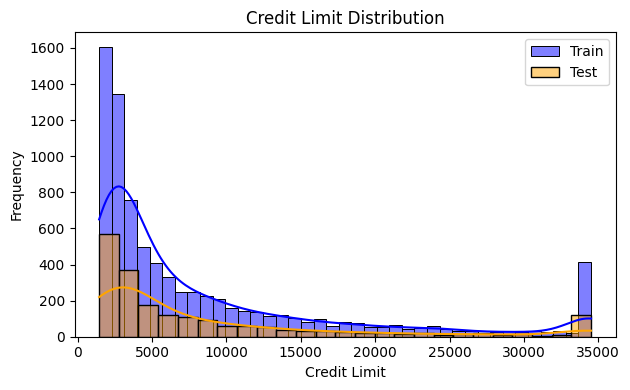

(8105, 20)


In [8]:
# Split the data
train_df, test_df = Preprocessing.split(df, 0.2, 42)

# Plot the distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(train_df['Credit_Limit'], kde=True, color='blue', label='Train')
sns.histplot(test_df['Credit_Limit'], kde=True, color='orange', label='Test')
plt.title('Credit Limit Distribution')
plt.xlabel('Credit Limit')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print(train_df.shape)


# Data Analisys


In [9]:
nan_counts = train_df.isna().sum().sort_values(ascending=False)
summary = pd.concat([train_df.info(), nan_counts], axis=0)
summary

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 4984 to 7270
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8105 non-null   float64
 1   Dependent_count           8105 non-null   int64  
 2   Education_Level           8105 non-null   int64  
 3   Income_Category           8105 non-null   int64  
 4   Card_Category             6586 non-null   float64
 5   Months_on_book            7921 non-null   float64
 6   Total_Relationship_Count  8087 non-null   float64
 7   Months_Inactive_12_mon    8105 non-null   int64  
 8   Contacts_Count_12_mon     8105 non-null   int64  
 9   Credit_Limit              8105 non-null   float64
 10  Total_Revolving_Bal       8105 non-null   int64  
 11  Total_Amt_Chng_Q4_Q1      8105 non-null   float64
 12  Total_Trans_Amt           8105 non-null   int64  
 13  Total_Trans_Ct            8105 non-null   int64  
 14  Total_Ct_C

Marital_Status_Unknown      1529
Marital_Status_Single       1529
Marital_Status_Married      1529
Card_Category               1519
Months_on_book               184
Gender_M                     158
Total_Relationship_Count      18
Total_Trans_Amt                0
Avg_Utilization_Ratio          0
Total_Ct_Chng_Q4_Q1            0
Total_Trans_Ct                 0
Customer_Age                   0
Total_Amt_Chng_Q4_Q1           0
Dependent_count                0
Credit_Limit                   0
Contacts_Count_12_mon          0
Months_Inactive_12_mon         0
Income_Category                0
Education_Level                0
Total_Revolving_Bal            0
dtype: int64

In [10]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(7)

,Total,%
Marital_Status_Unknown,1529,18.9
Marital_Status_Single,1529,18.9
Marital_Status_Married,1529,18.9
Card_Category,1519,18.7
Months_on_book,184,2.3
Gender_M,158,1.9
Total_Relationship_Count,18,0.2


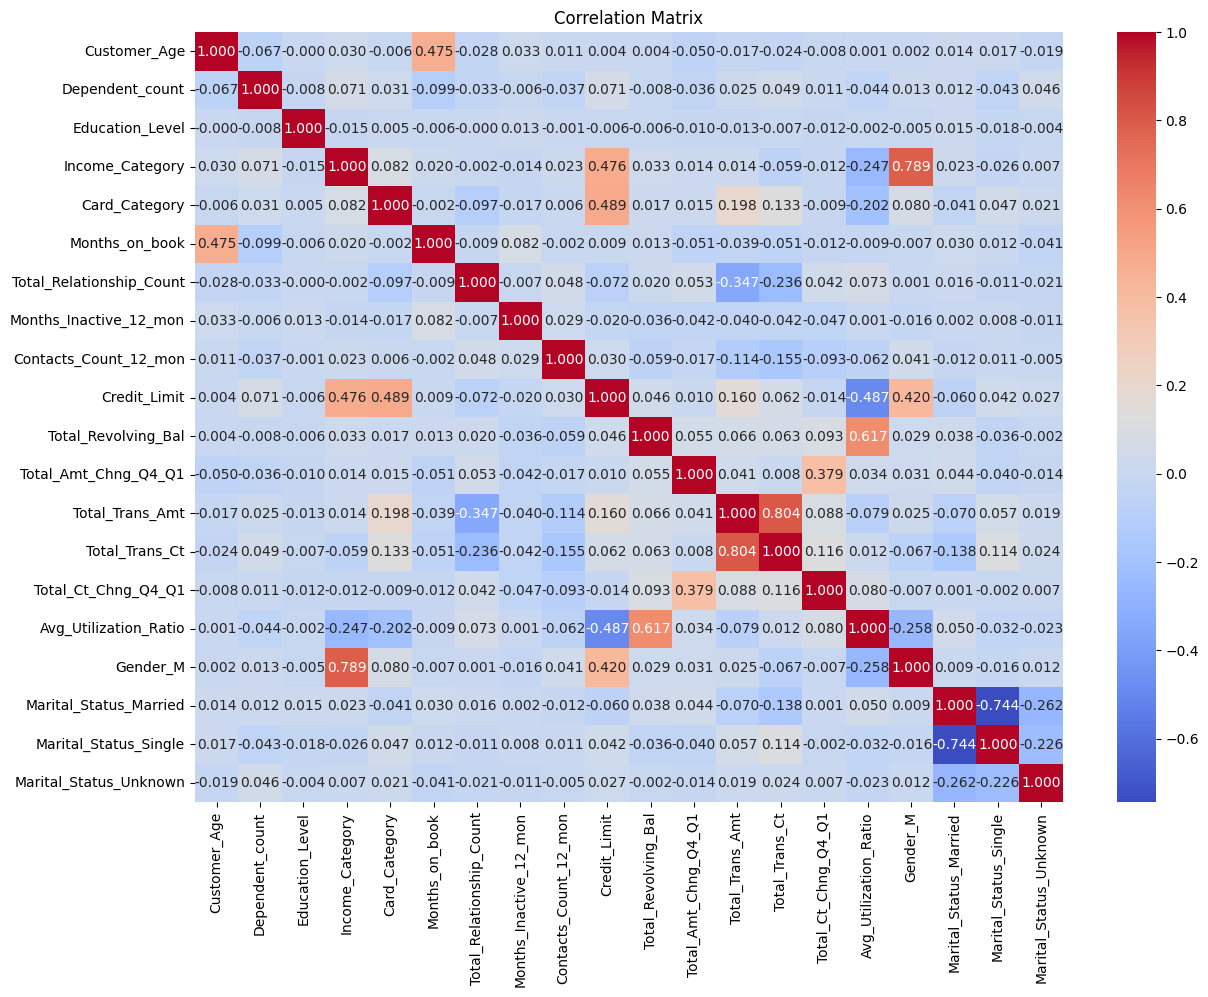

In [11]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Matrix')
plt.show()

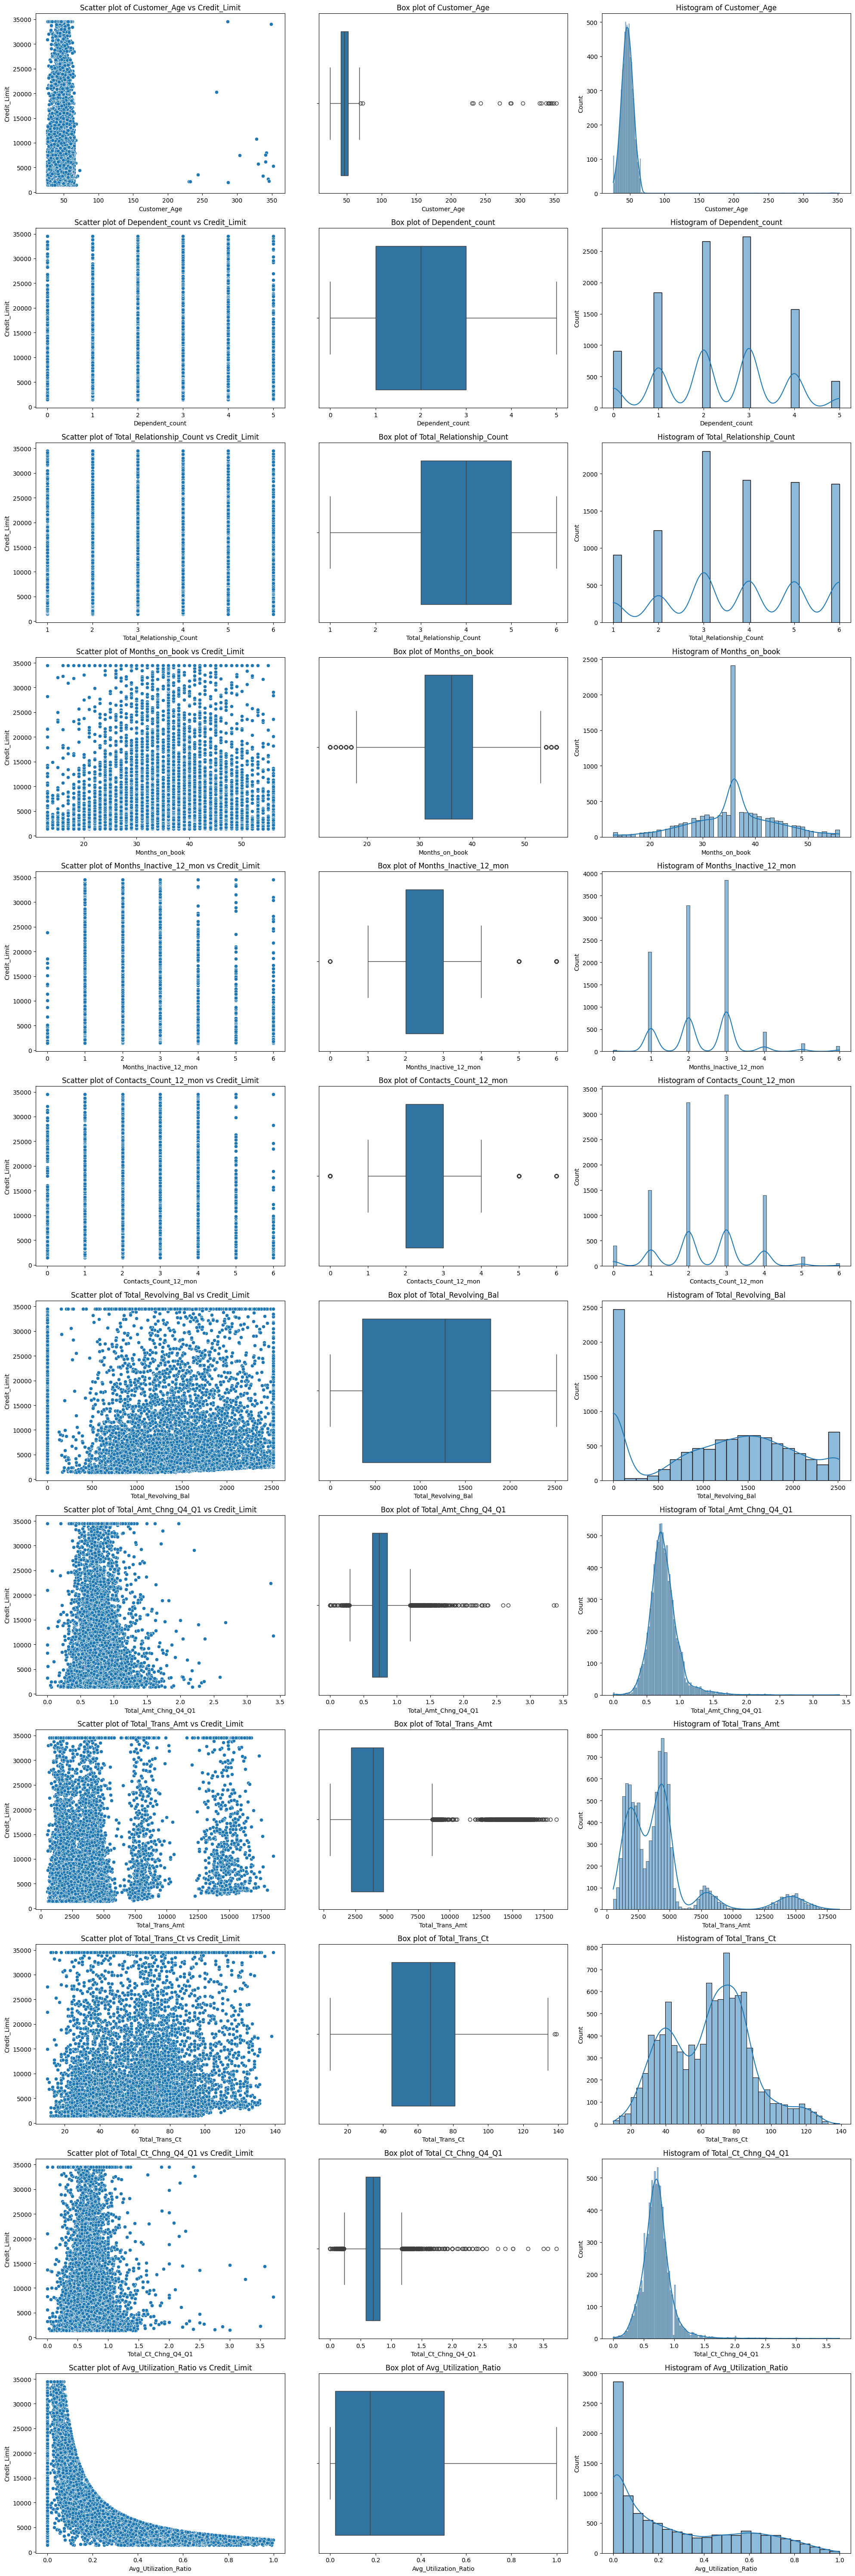

In [12]:
numeric_features = ['Customer_Age', 'Dependent_count', 'Total_Relationship_Count', 'Months_on_book', 
                    'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 
                    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 
                    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


plt.figure(figsize=(20, 5 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    # Scatter plot
    plt.subplot(len(numeric_features), 3, 3*i + 1)
    sns.scatterplot(data=df, x=feature, y='Credit_Limit')
    plt.title(f'Scatter plot of {feature} vs Credit_Limit')

    # Box plot to identify out
    plt.subplot(len(numeric_features), 3, 3*i + 2)
    sns.boxplot(x=df[feature])
    plt.title(f'Box plot of {feature}')

    # Histogram to understan distribiution
    plt.subplot(len(numeric_features), 3, 3*i + 3)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

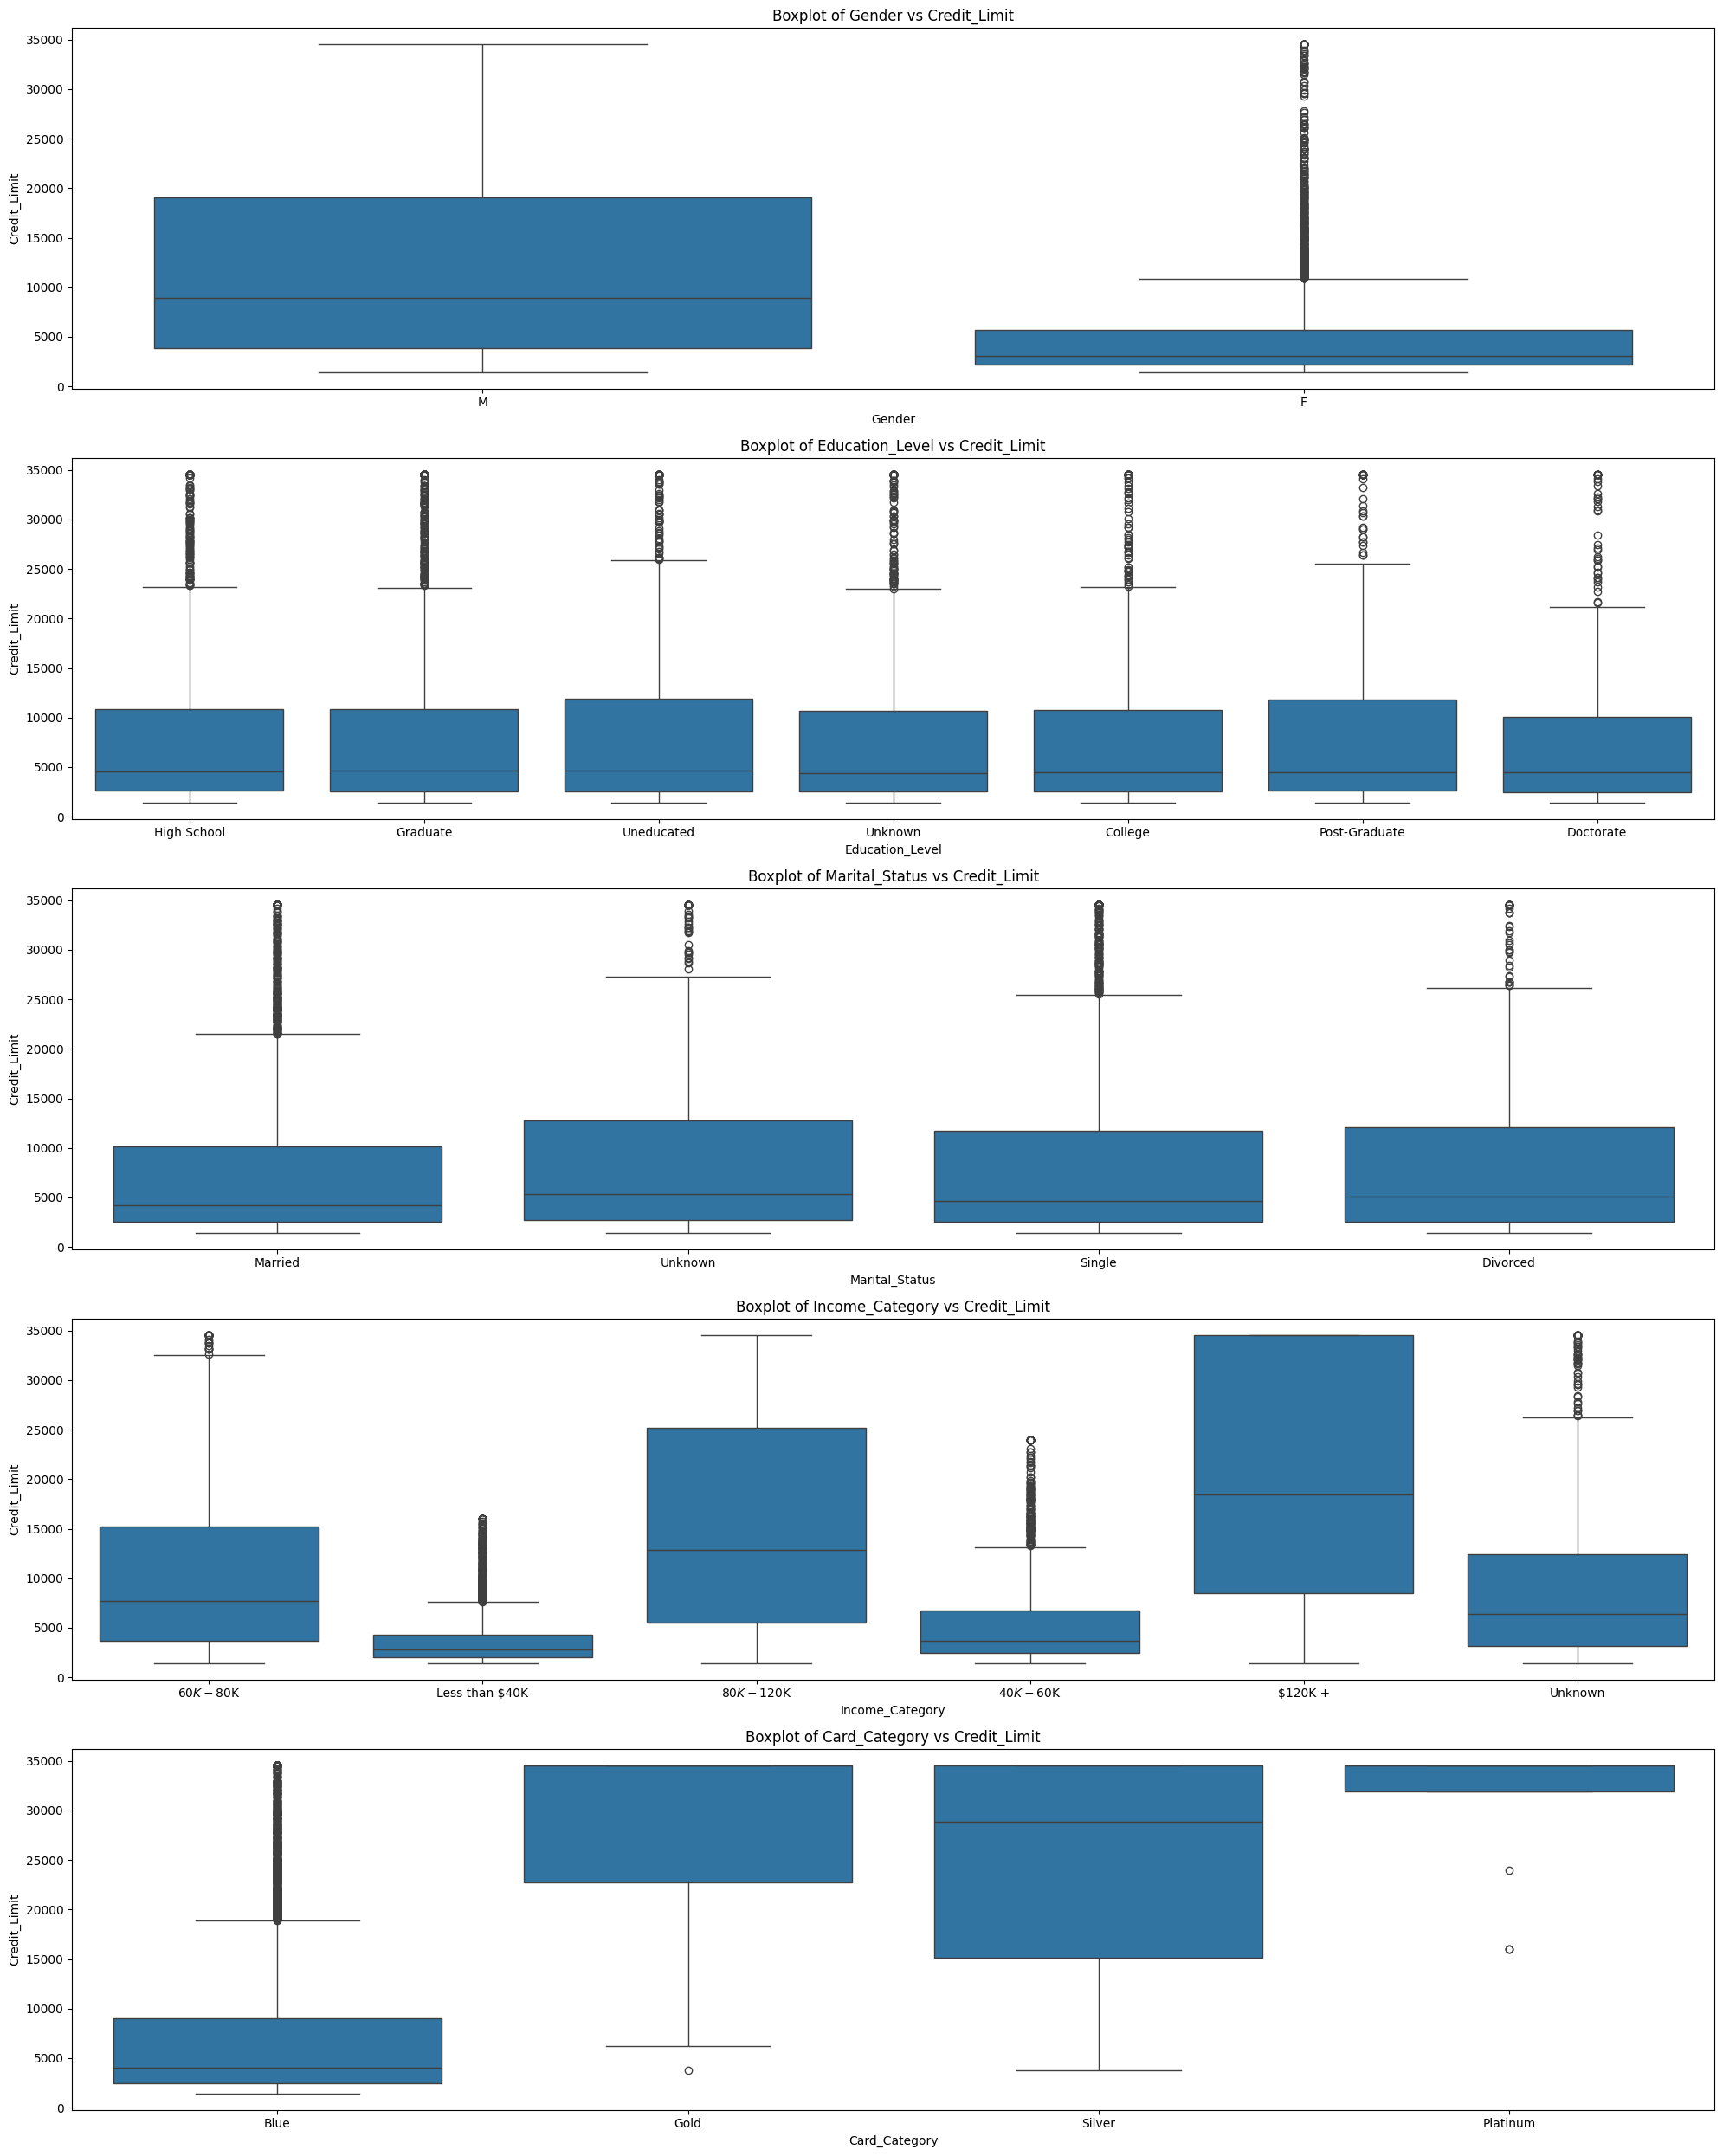

In [13]:
# Identify categorical features
categorical_features = df_copy.select_dtypes(include="object").columns

plt.figure(figsize=(20, 5 * len(categorical_features)))

for i, feature in enumerate(categorical_features):
    # Categorical plot
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.boxplot(data=df_copy, x=feature, y='Credit_Limit')
    plt.title(f'Boxplot of {feature} vs Credit_Limit')

plt.tight_layout()
plt.show()

<Axes: >

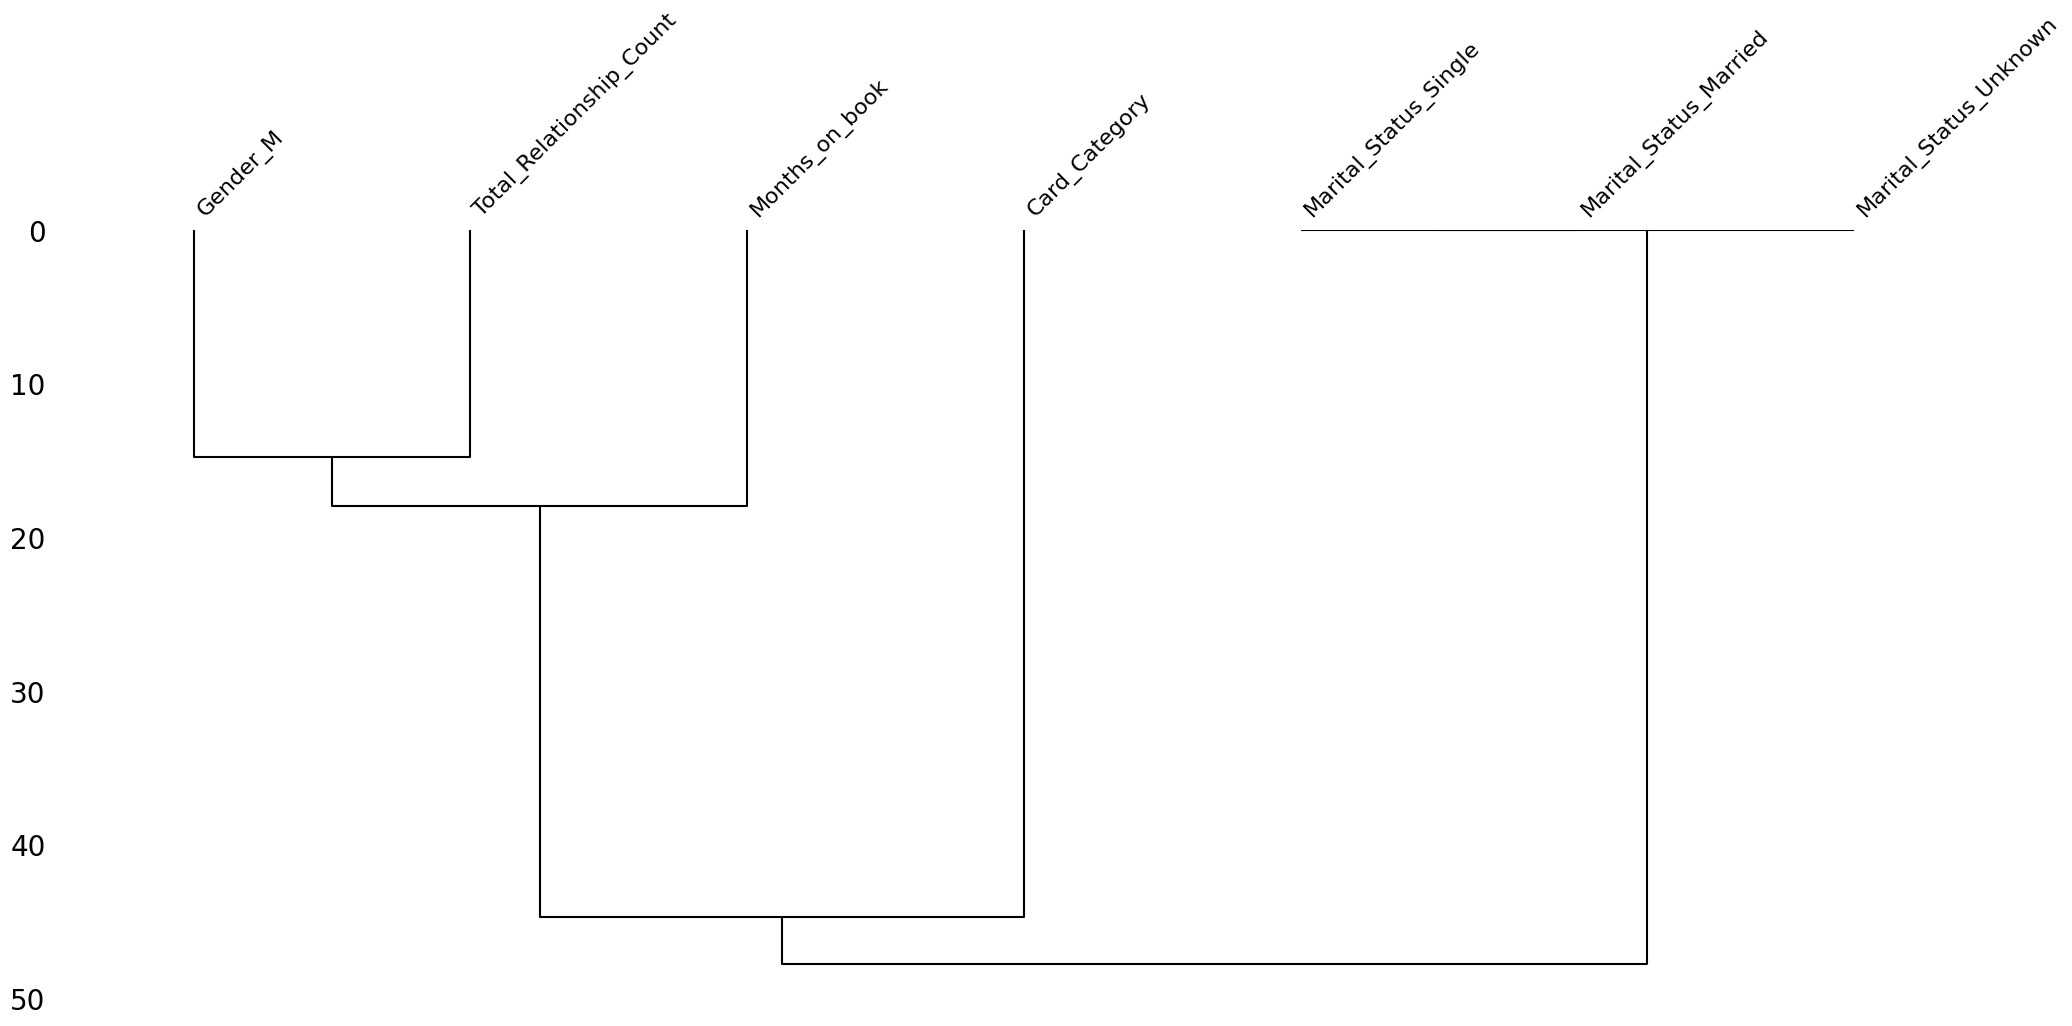

In [14]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
msno.dendrogram(df[missing_columns])


# Missing Values Treatment


In [15]:
train_df = Preprocessing.tree_imputation(train_df)
test_df = Preprocessing.tree_imputation(test_df)

train_df.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
4984,52.0,3,4,1,0.0,39.0,4.0,3,3,2001.0,909,0.772,4238,63,0.800,0.454,0.0,1.0,0.0,0.0
3550,52.0,2,2,1,0.0,40.0,3.0,1,3,1960.0,1428,0.570,3782,64,0.641,0.729,0.0,0.0,1.0,0.0
1937,34.0,2,4,4,0.0,29.0,3.0,1,3,13395.0,1678,1.006,2650,69,0.865,0.125,1.0,0.0,1.0,0.0
4480,50.0,4,2,2,0.0,36.0,6.0,1,1,1479.0,1004,0.827,5116,75,0.974,0.679,0.0,1.0,0.0,0.0
8553,50.0,3,2,1,0.0,42.0,1.0,3,2,1477.0,0,0.685,4680,80,0.778,0.000,0.0,0.0,1.0,0.0



# Outlier Detection and Tretment


In [16]:
df_copy.select_dtypes(exclude="object").columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [17]:
outlier_detection_columns = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                             'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal',
                             'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
                             'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

In [18]:
Preprocessing.treat_outlier(train_df.copy(), outlier_detection_columns)

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
4984,52.0,3.0,4,1,0.0,39.0,4.0,3.0,3.0,2001.0,909.0,0.772,4238.0,63.0,0.800,0.454,0.0,1.0,0.0,0.0
3550,52.0,2.0,2,1,0.0,40.0,3.0,1.0,3.0,1960.0,1428.0,0.570,3782.0,64.0,0.641,0.729,0.0,0.0,1.0,0.0
1937,34.0,2.0,4,4,0.0,29.0,3.0,1.0,3.0,13395.0,1678.0,1.006,2650.0,69.0,0.865,0.125,1.0,0.0,1.0,0.0
4480,50.0,4.0,2,2,0.0,36.0,6.0,1.0,1.0,1479.0,1004.0,0.827,5116.0,75.0,0.974,0.679,0.0,1.0,0.0,0.0
8553,50.0,3.0,2,1,0.0,42.0,1.0,3.0,2.0,1477.0,0.0,0.685,4680.0,80.0,0.778,0.000,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,44.0,1.0,4,2,0.0,38.0,3.0,2.0,4.0,4142.0,2517.0,0.809,2104.0,44.0,0.833,0.608,0.0,0.0,1.0,0.0
5191,53.0,3.0,2,0,0.0,36.0,4.0,3.0,4.0,7939.0,0.0,0.551,2269.0,42.0,0.312,0.000,0.0,0.0,0.0,0.0
5390,42.0,4.0,4,1,0.0,32.0,3.0,1.0,2.0,2314.0,1547.0,0.804,4678.0,74.0,1.000,0.669,0.0,0.0,0.0,1.0
860,40.0,3.0,0,2,0.0,28.0,4.0,1.0,1.0,3563.0,1707.0,0.506,1482.0,42.0,0.312,0.479,1.0,0.0,1.0,0.0



# Feature Selection


In [19]:
def vif_importance(data):

    vif_data = pd.DataFrame()
    vif_data['Feature'] = train_df.columns
    vif_data['VIF'] = [variance_inflation_factor(train_df.values, i) for i in range(train_df.shape[1])]
    
    
    X = train_df.drop('Credit_Limit', axis='columns')
    y = train_df['Credit_Limit']
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    })
    
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    combined_data = pd.merge(feature_importances, vif_data, on='Feature', how='inner')
    
    info = combined_data.sort_values(by='Importance', ascending=False)
    return info

In [20]:
# info = vif_importance(train_df)

In [21]:
# print(info)

In [22]:
columns_to_remove = ['Gender_M', 'Marital_Status_Unknown', 'Months_Inactive_12_mon',
                    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Months_on_book', 'Customer_Age']

In [23]:
# train_df = train_df.drop(columns_to_remove, axis='columns')
# test_df = test_df.drop(columns_to_remove, axis='columns')

In [24]:
print(train_df.shape)

(8105, 20)


In [25]:
# PCA

# pca = PCA(n_components=15)  # Set the number of principal components
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)


# Scaling


In [26]:
x_train = train_df.drop('Credit_Limit', axis='columns')
x_test = test_df.drop('Credit_Limit', axis='columns')

y_train = train_df['Credit_Limit']
y_test = test_df['Credit_Limit']

In [27]:
print(f"x_train : {x_train.shape}")
print(f"y_train : {y_train.shape}")

x_train : (8105, 19)
y_train : (8105,)


In [28]:
x_train, x_test = Preprocessing.scale(x_train, x_test)

In [29]:
print(x_train)

[[0.07967382 0.6        0.66666667 ... 1.         0.         0.        ]
 [0.07967382 0.4        0.33333333 ... 0.         1.         0.        ]
 [0.02451502 0.4        0.66666667 ... 0.         1.         0.        ]
 ...
 [0.04903005 0.8        0.66666667 ... 0.         0.         1.        ]
 [0.04290129 0.6        0.         ... 0.         1.         0.        ]
 [0.0827382  0.8        0.33333333 ... 0.         1.         0.        ]]



# Tain Model and Evaluate


In [30]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
rf.fit(x_train, y_train)
        
oob_score = rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
        
y_pred = rf.predict(x_test)
        
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
        
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2): {r2}')

Out-of-Bag Score: 0.8847402038723503
Mean Squared Error (MSE): 10012995.086230002
R-squared (R2): 0.8823791371223041


In [31]:
'''

Out-of-Bag Score: 0.8871661646762087
Mean Squared Error (MSE): 9697483.072144547
R-squared (R2): 0.8860854003358002

'''

'\n\nOut-of-Bag Score: 0.8871661646762087\nMean Squared Error (MSE): 9697483.072144547\nR-squared (R2): 0.8860854003358002\n\n'

In [32]:
X = train_df.drop('Credit_Limit', axis='columns')
y = train_df['Credit_Limit']

kmeans = KMeans(n_clusters=4)  # Set the number of clusters as desired
clusters = kmeans.fit_predict(X)

regressors = {}

for cluster_label in range(kmeans.n_clusters):
    # Filter data points belonging to the current cluster
    X_cluster = X[clusters == cluster_label]
    y_cluster = y[clusters == cluster_label]
    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
    
    regressor = RandomForestRegressor()
    regressor.fit(X_train_c, y_train_c)
    
    regressors[cluster_label] = regressor
    
    score = regressor.score(X_test_c, y_test_c)
    print(f"Cluster {cluster_label}: R^2 Score = {score}")

new_clusters = kmeans.predict(test_df.drop('Credit_Limit', axis='columns'))

for i, cluster_label in enumerate(new_clusters):
    X_new_cluster = test_df.drop('Credit_Limit', axis='columns')[i:i+1]  
    predicted_value = regressors[cluster_label].predict(X_new_cluster)
    # print(f"Predicted value for data point {i}: {predicted_value}")


D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: R^2 Score = 0.8881611202998649
Cluster 1: R^2 Score = 0.9370565507888574
Cluster 2: R^2 Score = 0.8738752806304456
Cluster 3: R^2 Score = 0.8224634288739328


In [33]:
total_samples = len(X)  
total_r2 = 0  

for cluster_label in range(kmeans.n_clusters):
    X_cluster = X[clusters == cluster_label]
    y_cluster = y[clusters == cluster_label]
    
    cluster_weight = len(X_cluster) / total_samples
    regressor = regressors[cluster_label]
    r2_score = regressor.score(X_cluster, y_cluster)
    total_r2 += cluster_weight * r2_score

print(f"Total R^2 score: {total_r2}")


Total R^2 score: 0.9598540489898357


In [34]:
total_samples = len(X)  
total_mse = 0  

for cluster_label in range(kmeans.n_clusters):
    X_cluster = X[clusters == cluster_label]
    y_cluster = y[clusters == cluster_label]
    
    cluster_weight = len(X_cluster) / total_samples
    regressor = regressors[cluster_label]
    y_pred = regressor.predict(X_cluster)
    mse = mean_squared_error(y_cluster, y_pred)
    total_mse += cluster_weight * mse

print(f"Total MSE: {total_mse}")


Total MSE: 3063230.1091527976


In [35]:
'''
Total R^2 score: 0.959061602532588
Total MSE: 3264882.097322209
'''

'\nTotal R^2 score: 0.959061602532588\nTotal MSE: 3264882.097322209\n'